# Duck Egg Quality Classification Based on its Shell Visual Property through Image Processing and Deep Learning


Group CGM: <br>

Caguioa, JV Bryan <br>
Guinto, Ryhle Nodnyhlson <br>
Mesias, Lee Reuben

# References

https://thedatafrog.com/en/articles/image-recognition-transfer-learning/ <br>
https://medium.com/the-owl/k-fold-cross-validation-in-keras-3ec4a3a00538 <br>
https://www.datacamp.com/community/tutorials/convolutional-neural-networks-python

## Imports

In [1]:
# the directory where the data is stored
directory = "C:/Users/user/Desktop/Dataset"
#directory where set of models per training are stored
gen_dir = "C:/Users/user/Desktop/Model"

import os                                              # define and move to dataset and model directory
import random                                          # for image name
import shutil                                          # dupli
import sys
import cv2     

import tensorflow.keras as keras
import numpy as np
import tensorflow as tf                                 #for callbacks
import seaborn as sn
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt                         #histograph/confusion matrix

from sklearn.model_selection import StratifiedKFold     #k-fold cross validation
from sklearn.model_selection import train_test_split    #split the dataset to train-test

from tensorflow.keras.preprocessing.image import ImageDataGenerator      # data augmentation
from tensorflow.keras.preprocessing import image as im                   #load image
from tensorflow.keras.applications.resnet50 import preprocess_input      #preprocess image                                                               

from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, auc       
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import label_binarize

from scipy import interp                            #interpolation needed for plotting all classes into one roc plot
from itertools import cycle                         #for the color of lines on that multiclass plot

import warnings
warnings.filterwarnings("ignore")

## Put Dataset in a Dataframe

The directory of the images are put in a dataframe in order to prepare for splitting the dataset into train and test set.

In [2]:
totaldsdirect = directory + "/CombinedTwoAngleEggs"

image = []

if not os.path.exists(totaldsdirect):
    print("Directory does not exist. Please run the code on data cleaning notebook.")
    sys.exit()

for x in os.listdir(totaldsdirect):
    totaldsdirect2 = totaldsdirect + "/" + x
    for y in os.listdir(totaldsdirect2):
        if x == "Balut-penoy2":
            lbl = "0"
        elif x == "Salted egg2":
            lbl = "1"
        else:
            lbl = "2"
                 
        #append to image array
        image.append([totaldsdirect2 + "/" + y,lbl])

In [3]:
df = pd.DataFrame(image,columns=['filename','label'])
df

,filename,label
0,C:/Users/user/Desktop/Dataset/CombinedTwoAngle...,0
1,C:/Users/user/Desktop/Dataset/CombinedTwoAngle...,0
2,C:/Users/user/Desktop/Dataset/CombinedTwoAngle...,0
3,C:/Users/user/Desktop/Dataset/CombinedTwoAngle...,0
4,C:/Users/user/Desktop/Dataset/CombinedTwoAngle...,0
...,...,...
595,C:/Users/user/Desktop/Dataset/CombinedTwoAngle...,2
596,C:/Users/user/Desktop/Dataset/CombinedTwoAngle...,2
597,C:/Users/user/Desktop/Dataset/CombinedTwoAngle...,2
598,C:/Users/user/Desktop/Dataset/CombinedTwoAngle...,2


Classes: <br>
0 - Balut/Penoy <br> 
1 - Salted <br>
2 - Table

## Split Data to train and test set

We will need to split the dataset to train and test set. Only the train set will be used for transfer learning with K-fold validation. Test set will be used for model prediction and use that for model evaluation. Stratify is used in order to split the data in equal numbers under the classes specified.

In [4]:
# Split the data to train and test
X = df[['filename']]
y = df[['label']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=420)

Save the split sets to train and test set folders.

In [5]:
#folder to store the train and test set folders
fortraintest = directory + "/ToBeUsed"
if not os.path.exists(fortraintest):
    os.makedirs(fortraintest)

#train set folder
tr = fortraintest + "/train_set"
if not os.path.exists(tr):
    os.makedirs(tr)
else:
    #remove previous folder and create new one
    shutil.rmtree(tr)
    os.makedirs(tr)
    
#test set folder
te = fortraintest + "/test_set"
if not os.path.exists(te):
    os.makedirs(te)
else:
    #remove previous folder and create new one
    shutil.rmtree(te)
    os.makedirs(te)

#copying the images to the train set folder
for index, row in X_train.iterrows():
    trcpy = shutil.copy2(row['filename'], tr)
    X_train.loc[X_train['filename']==row['filename'],'filename']=trcpy #change to directory where image is copied
    
#copying the images to the test set folder
for index, row in X_test.iterrows():
    tecpy = shutil.copy2(row['filename'], te)
    X_test.loc[X_test['filename']==row['filename'],'filename']=tecpy #change to directory where image is copiedb

In [6]:
df2 = pd.concat([X_train,y_train],axis=1)
df2

,filename,label
11,C:/Users/user/Desktop/Dataset/ToBeUsed/train_s...,0
581,C:/Users/user/Desktop/Dataset/ToBeUsed/train_s...,2
377,C:/Users/user/Desktop/Dataset/ToBeUsed/train_s...,1
487,C:/Users/user/Desktop/Dataset/ToBeUsed/train_s...,2
216,C:/Users/user/Desktop/Dataset/ToBeUsed/train_s...,1
...,...,...
273,C:/Users/user/Desktop/Dataset/ToBeUsed/train_s...,1
486,C:/Users/user/Desktop/Dataset/ToBeUsed/train_s...,2
86,C:/Users/user/Desktop/Dataset/ToBeUsed/train_s...,0
200,C:/Users/user/Desktop/Dataset/ToBeUsed/train_s...,1


To check whether or not there are equal amounts of images per class in the train set, we have done what is shown below.

In [7]:
counto = [0,0,0]

counto_count = 0

for x in df2['label'].unique():
    for y in df2['label']:
        if x == y:
            if counto_count == 0:
                counto[0] += 1
            elif counto_count == 1:
                counto[1] += 1
            else:
                counto[2] += 1
                
    counto_count += 1

In [8]:
print(counto)

[180, 180, 180]


In [9]:
df3 = pd.concat([X_test,y_test],axis=1)
df3

,filename,label
177,C:/Users/user/Desktop/Dataset/ToBeUsed/test_se...,0
535,C:/Users/user/Desktop/Dataset/ToBeUsed/test_se...,2
563,C:/Users/user/Desktop/Dataset/ToBeUsed/test_se...,2
498,C:/Users/user/Desktop/Dataset/ToBeUsed/test_se...,2
502,C:/Users/user/Desktop/Dataset/ToBeUsed/test_se...,2
257,C:/Users/user/Desktop/Dataset/ToBeUsed/test_se...,1
559,C:/Users/user/Desktop/Dataset/ToBeUsed/test_se...,2
134,C:/Users/user/Desktop/Dataset/ToBeUsed/test_se...,0
298,C:/Users/user/Desktop/Dataset/ToBeUsed/test_se...,1
10,C:/Users/user/Desktop/Dataset/ToBeUsed/test_se...,0


Same with the train set, we checked whether or not there is an equal distribution of images

In [10]:
counto = [0,0,0]

counto_count = 0

for x in df3['label'].unique():
    for y in df3['label']:
        if x == y:
            if counto_count == 0:
                counto[0] += 1
            elif counto_count == 1:
                counto[1] += 1
            else:
                counto[2] += 1
                
    counto_count += 1

In [11]:
print(counto)

[20, 20, 20]


## Functions

### Create Plot History

Plot history will display the training and validation accuracy, and training and validation loss in every epoch in a fold.

In [12]:
def plot_history(history, yrange):
    #Plot loss and accuracy as a function of the epoch,
    #for the training and validation datasets.
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get number of epochs
    epochs = range(len(acc))

    # Plot training and validation accuracy per epoch
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title('Training and validation accuracy')
    plt.legend(['train_accuracy','val_accuracy'])
    plt.ylim(yrange)
    
    # Plot training and validation loss per epoch
    plt.figure()

    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.title('Training and validation loss')
    plt.legend(['train_loss','val_loss'])
    
    plt.show() 

### Save Models

K-fold cross validation will be used in training the model.The set of models produced per fold will be saved in an automatic generated folder. Every training will generated another folder to save the new set of models.

In [13]:
def savemodel():
    save_cur = ""  #check if there is any saved_models folders

    svnum = 0
    svnum2 = 0

    for x in os.listdir(gen_dir):
        if "saved_models" in x:
            save_cur = x
            if not save_cur == "":
                for word in save_cur.split("_"):
                    if word.isdigit():
                        svnum2 = int(word)
                        if svnum < svnum2:
                            svnum = svnum2


    #save_dir is where the created models using the current set of parameters are added        
    if save_cur == "":
        save_dir = gen_dir + "/saved_models_1"
        os.makedirs(save_dir)
    else:
        save_dir = gen_dir + "/saved_models_" + str(svnum + 1)
        os.makedirs(save_dir)
        
    return save_dir

## Data Augmentation

We will apply data augmentation to the dataset to increase the accuracy of the models. For the training and validation set, we will use data augmentation per epoch in order to generate unique images in order to increase the dataset. For the test set, we will apply the same preprocessing used for the training and validation set so that it will match with the generated images.

### For training set and validation set

In [14]:
resnet50 = keras.applications.resnet50

imgdatagen = ImageDataGenerator(
        preprocessing_function = resnet50.preprocess_input,
        horizontal_flip = True,
        vertical_flip = True,
        width_shift_range = 10,
        height_shift_range = 10,
        rotation_range = 5,
        brightness_range = [0.8,1.3],
        fill_mode = "nearest"
    )

### For test set

In [15]:
resnet50 = keras.applications.resnet50

imgdatagen2 = ImageDataGenerator(
        preprocessing_function = resnet50.preprocess_input,
    )

## Model Creation

The model will be based on ResNet50 Architecture. The classifier block will be changed to suit to our dataset.

In [16]:
def create_model():
    conv_model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

    for layer in conv_model.layers:
        layer.trainable = False

    x = keras.layers.GlobalAveragePooling2D()(conv_model.output)
    x = keras.layers.Dense(512, activation='relu')(x)
    x = keras.layers.Dense(256, activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.2)(x)
    predictions = keras.layers.Dense(3, activation='softmax')(x)

    full_model = keras.models.Model(inputs=conv_model.input, outputs=predictions)

    return full_model

In [17]:
full_model = create_model()
full_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

## Hyper-Parameter Tuning

We will check the parameters that yielded the best results. A set of values on chosen parameters is given. The one that will yield the best results will be used for prediction.

### Model Parameters

In [29]:
batch_size_arr = [200]                              #batch size
num_epochs_arr = [1]                                #number of epochs
lr_arr = [0.0001]                                   #learning rate Adamax

### Initialize Variables

In [30]:
VALIDATION_ACCURACY = []                          #holds all validation_accuracy
VALIDATION_LOSS = []                              #holds all validation_loss

TRAIN_ACCURACY = []                               #holds all train_accuracy
TRAIN_LOSS = []                                   #holds all train_loss

TEST_ACCURACY = []                                #holds all test_accuracy
TEST_LOSS = []                                    #holds all test_loss

param_arr = []                                    #holds the parameter values per combination

val_acc_arr = []                                  #holds the set of validation accuracy per combination
val_loss_arr = []                                 #holds the set of validation loss per combination
val_acc_means = []                                #holds the means of all set of validation accuracy per combination
val_loss_means = []                               #holds the means of all set of validation loss per combination

train_acc_arr = []                                #holds the set of train accuracy per combination
train_loss_arr = []                               #holds the set of train loss per combination
train_acc_means = []                              #holds the means of all set of train accuracy per combination
train_loss_means = []                             #holds the means of all set of train loss per combination

test_acc_arr = []                                 #holds the set of test accuracy per combination
test_loss_arr = []                                #holds the set of test loss per combination
test_acc_means = []                               #holds the means of all set of test accuracy per combination
test_loss_means = []                              #holds the means of all set of test loss per combination

### Train, Validation, Test data settings

In [31]:
train_dir = directory + "/ToBeUsed/train_set"     #where the train set images are stored
test_dir = directory + "/ToBeUsed/test_set"

#kfold parameters
Y = df2[['label']]
skf = StratifiedKFold(n_splits = 5, random_state = 69, shuffle = True)

yt = pd.to_numeric(y_test['label'])                #make the labels to integer to get the model metrics

Train the model per combination of parameters.


batch size:  200
epochs:  1
learning rate:  0.0001


Fold number 1
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.
Found 60 validated image filenames belonging to 3 classes.
3/3 [==============================] - 15s 4s/step - loss: 1.5848 - accuracy: 0.3079 - val_loss: 1.3425 - val_accuracy: 0.3333

Epoch 00001: val_accuracy improved from -inf to 0.33333, saving model to C:/Users/user/Desktop/Model/saved_models_1\model_1.h5


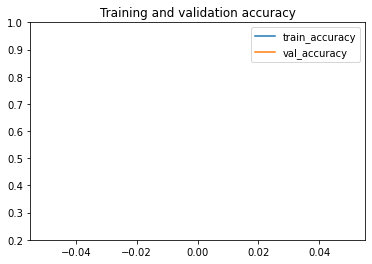

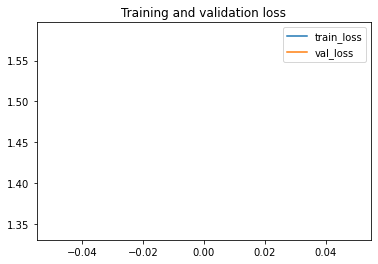

1/1 [==============================] - 2s 2s/step - loss: 1.3057 - accuracy: 0.3333

Fold number 2
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.
Found 60 validated image filenames belonging to 3 classes.
3/3 [==============================] - 14s 5s/step - loss: 1.4185 - accuracy: 0.3588 - val_loss: 1.7407 - val_accuracy: 0.3333

Epoch 00001: val_accuracy improved from -inf to 0.33333, saving model to C:/Users/user/Desktop/Model/saved_models_1\model_2.h5


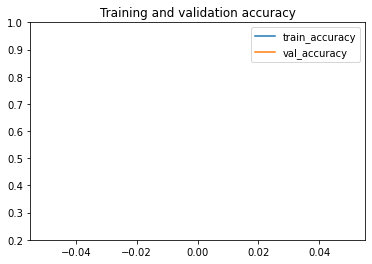

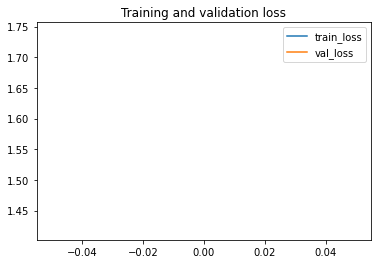

1/1 [==============================] - 2s 2s/step - loss: 1.7800 - accuracy: 0.3333

Fold number 3
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.
Found 60 validated image filenames belonging to 3 classes.
3/3 [==============================] - 18s 5s/step - loss: 1.6625 - accuracy: 0.2986 - val_loss: 1.3432 - val_accuracy: 0.3426

Epoch 00001: val_accuracy improved from -inf to 0.34259, saving model to C:/Users/user/Desktop/Model/saved_models_1\model_3.h5


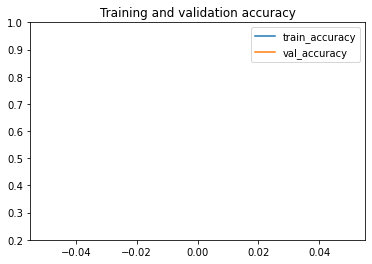

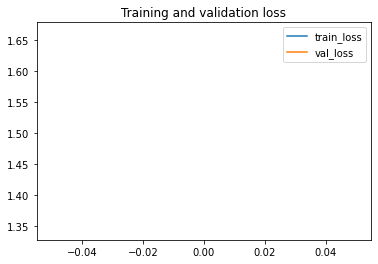

1/1 [==============================] - 3s 3s/step - loss: 1.3540 - accuracy: 0.3333

Fold number 4
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.
Found 60 validated image filenames belonging to 3 classes.
3/3 [==============================] - 15s 4s/step - loss: 1.3745 - accuracy: 0.3958 - val_loss: 1.0114 - val_accuracy: 0.3981

Epoch 00001: val_accuracy improved from -inf to 0.39815, saving model to C:/Users/user/Desktop/Model/saved_models_1\model_4.h5


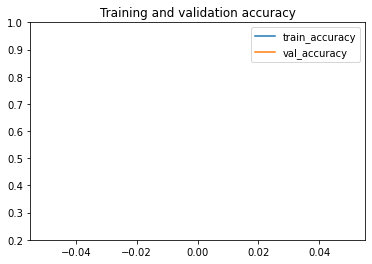

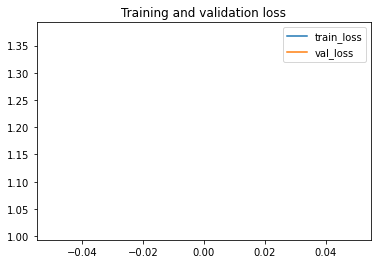

1/1 [==============================] - 2s 2s/step - loss: 0.9852 - accuracy: 0.5278

Fold number 5
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.
Found 60 validated image filenames belonging to 3 classes.
3/3 [==============================] - 14s 4s/step - loss: 1.3191 - accuracy: 0.4005 - val_loss: 1.1646 - val_accuracy: 0.3519

Epoch 00001: val_accuracy improved from -inf to 0.35185, saving model to C:/Users/user/Desktop/Model/saved_models_1\model_5.h5


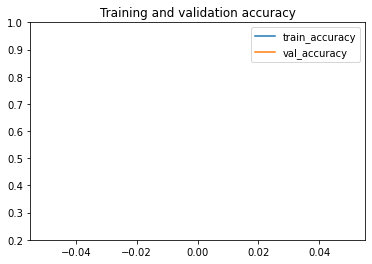

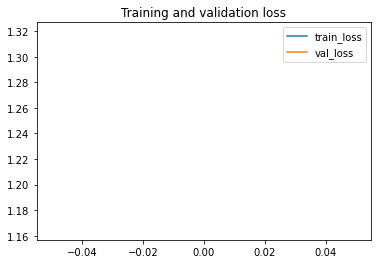

1/1 [==============================] - 2s 2s/step - loss: 1.1741 - accuracy: 0.3611


In [32]:
for x in range(len(batch_size_arr)):
    
    #for batch size values
    if len(param_arr) == 0:
        param_arr.append([])
    
    for y in range(len(num_epochs_arr)):

        #for epoch values
        if len(param_arr) == 1:
            param_arr.append([])
        
        for z in range(len(lr_arr)):
            
            #for learning rate values
            if len(param_arr) == 2:
                param_arr.append([])
                
            print('')
            print("batch size: ", batch_size_arr[x])
            print("epochs: ", num_epochs_arr[y])
            print("learning rate: ", lr_arr[z])
            print('')
            
            #append the values per combo
            param_arr[0].append(batch_size_arr[x])
            param_arr[1].append(num_epochs_arr[y])
            param_arr[2].append(lr_arr[z])
            
            VALIDATION_ACCURACY = []
            VALIDATION_LOSS = []
            
            TRAIN_ACCURACY = []
            TRAIN_LOSS = []
            
            TEST_ACCURACY = []
            TEST_LOSS = []
            
            #change save_dir value per combination
            save_dir = savemodel()
            fold_var = 1
            
            for train_index, val_index in skf.split(np.zeros(len(df2)),Y):

                training_data = df2.iloc[train_index]
                validation_data = df2.iloc[val_index]
                
                print('')
                print("Fold number " + str(fold_var))
                
                train_data_generator = imgdatagen.flow_from_dataframe(training_data, directory = train_dir,
                                       x_col = "filename", y_col = "label",
                                       class_mode = "categorical", target_size = (224,224), batch_size = batch_size_arr[x],
                                            shuffle = True)
                valid_data_generator  = imgdatagen.flow_from_dataframe(validation_data, directory = train_dir,
                                        x_col = "filename", y_col = "label",
                                        class_mode = "categorical", target_size = (224,224), batch_size = batch_size_arr[x],
                                            shuffle = True)
                
                test_data = df3
                
                test_data_preprocessed = imgdatagen2.flow_from_dataframe(test_data, directory = test_dir,
                                         x_col = "filename", y_col = "label")
                
                full_model = create_model()
                # Compile the model
                full_model.compile(loss='categorical_crossentropy',
                              optimizer=keras.optimizers.Adamax(learning_rate=lr_arr[z]),
                              metrics=['accuracy']) #categorical_crossentropy cause it is more than 2 classes

                # Create callbacks
                checkpoint = tf.keras.callbacks.ModelCheckpoint((save_dir+"/"+ "model_" + str(fold_var) + ".h5"), 
                                        monitor='val_accuracy', verbose=1, 
                                        save_best_only=True, mode='max')
                callbacks_list = [checkpoint]
                # This saves the best model


                # Fit the model
                history = full_model.fit(train_data_generator,
                                         epochs=num_epochs_arr[y],
                                         callbacks=callbacks_list,
                                         validation_data=valid_data_generator,
                                         verbose=1)

                # Plot the history
                plot_history(history, yrange=(0.2,1))

                # Load the best model instance to evaluate the performance of the model
                full_model.load_weights(save_dir+"/model_"+str(fold_var)+".h5")

                results = full_model.evaluate(valid_data_generator)
                results = dict(zip(full_model.metrics_names,results))
                
                results2 = full_model.predict(valid_data_generator)
                
                # Store Validation accuracy/loss
                VALIDATION_ACCURACY.append(results['accuracy'])
                VALIDATION_LOSS.append(results['loss'])
                
                # Store Train accuracy/loss
                TRAIN_ACCURACY.append(np.mean(history.history['accuracy']))
                TRAIN_LOSS.append(np.mean(history.history['loss']))
                
                # Predict test set to get the test accuracy/loss
                yhat_probs = full_model.predict(test_data_preprocessed, verbose=0)
                yhat_classes = yhat_probs.argmax(axis=-1)
                
                # Test accuracy and loss score
                accuracy = accuracy_score(yt, yhat_classes)
                loss = log_loss(yt, yhat_probs)
                
                # Store Test accuracy and loss
                TEST_ACCURACY.append(accuracy)
                TEST_LOSS.append(loss)
                
                tf.keras.backend.clear_session()

                fold_var += 1
                
            val_acc_arr.append(VALIDATION_ACCURACY)
            val_loss_arr.append(VALIDATION_LOSS)
            
            train_acc_arr.append(TRAIN_ACCURACY)                            
            train_loss_arr.append(TRAIN_LOSS)
            
            test_acc_arr.append(TEST_ACCURACY)
            test_loss_arr.append(TEST_LOSS)

In [33]:
stopper

NameError: name 'stopper' is not defined

### Display Values Per Combination of Parameters

We will put the combination of parameters and the resulting means of accuracy and loss together in a dataframe in order to display it nicely.

In [34]:
#append means of accuracy and loss sets per combo
for x in range(len(val_acc_arr)):
    val_acc_means.append(np.mean(val_acc_arr[x]))                                
    val_loss_means.append(np.mean(val_loss_arr[x]))
    
    train_acc_means.append(np.mean(train_acc_arr[x]))                              
    train_loss_means.append(np.mean(train_loss_arr[x]))                             

    test_acc_means.append(np.mean(test_acc_arr[x]))                               
    test_loss_means.append(np.mean(test_loss_arr[x])) 
    
df_hyperparam = pd.DataFrame(list(zip(param_arr[0],param_arr[1],param_arr[2],
                                      train_acc_means, train_loss_means,
                                      val_acc_means,val_loss_means,
                                      test_acc_means, test_loss_means))
                             ,columns=['batch size','number of epoch', 'learning rate', 
                                       'train accuracy', 'train loss',
                                       'val accuracy', 'val loss',
                                       'test accuracy', 'test loss'])

df_hyperparam = df_hyperparam.sort_values(ascending=False,by = 'val accuracy')

#df_hyperparam.to_excel("hyperparam_result.xlsx")

df_hyperparam



,batch size,number of epoch,learning rate,train accuracy,train loss,val accuracy,val loss,test accuracy,test loss
0,200,1,0.0001,0.352315,1.471866,0.377778,1.319797,0.35,1.404621


In [ ]:
stopper

### Each fold results of a selected model

Below are the validation accuracy and validation loss per fold and their average of the best combination.

In [36]:
comb_no = 0
fold_num = [*range(1,6)]

fold_eval = pd.DataFrame(list(zip(fold_num,train_acc_arr[comb_no],train_loss_arr[comb_no],
                                  val_acc_arr[comb_no],val_loss_arr[comb_no],
                                  test_acc_arr[comb_no],test_loss_arr[comb_no]))
                         ,columns=['fold','Training Accuracy','Training Loss',
                                   'Validation Accuracy','Validation Loss',
                                   'Test Accuracy','Test Loss'])

fold_eval.set_index('fold', inplace=True)
fold_eval.loc['mean'] = fold_eval.mean()

#fold_eval.to_excel('fold_eval.xlsx')
fold_eval

,Training Accuracy,Training Loss,Validation Accuracy,Validation Loss,Test Accuracy,Test Loss
fold,,,,,,
1,0.307870,1.584765,0.333333,1.305660,0.383333,1.153930
2,0.358796,1.418512,0.333333,1.779964,0.333333,1.884528
3,0.298611,1.662450,0.333333,1.354014,0.333333,1.550761
4,0.395833,1.374478,0.527778,0.985250,0.383333,1.125639
5,0.400463,1.319125,0.361111,1.174096,0.316667,1.308246
mean,0.352315,1.471866,0.377778,1.319797,0.350000,1.404621


## Model Prediction and Evaluation

Load the images in the test set and predict what class it is in all models of the best combination. There are three values of confidence level. The one with the highest confidence level is the predicted class of the image. The order of classes is [0 1 2]. The results will be feed to the eval function defined below in order to get the metrics.

In [ ]:
#make the labels to integer to get the model metrics
yt = pd.to_numeric(y_test['label'])

The content displayed are the metrics, roc auc of each class (balut/penoy,salted,table), and confusion matrix per fold, as well as the sum and mean of those confusion matrices and roc auc of each class for all folds.

In [ ]:
#Metrics
def evaluate(yhat_probs, 
             yhat_classes, 
             total_acc,
             total_loss,
             total_precision, 
             total_recall,
             tot_acc_per_class,
             tot_prec_per_class,
             tot_rec_per_class,
             matrix_sum,
             fold_num,
             fpr_total,
             tpr_total):

    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(yt, yhat_classes)
    total_acc.append(accuracy)
    print('Accuracy: %f' % accuracy)
    matrix = confusion_matrix(yt, yhat_classes)
    accuracy2 = matrix.diagonal()/matrix.sum(axis=1)
    tot_acc_per_class.append(accuracy2)
    print('Accuracy per class: ' + str(accuracy2))
    # loss
    loss = log_loss(yt, yhat_probs)
    total_loss.append(loss)
    print('Loss: %f' % loss)
    # precision tp / (tp + fp)
    precision = precision_score(yt, yhat_classes, average="weighted")
    total_precision.append(precision)
    print('Precision: %f' % precision)
    precision2 = precision_score(yt, yhat_classes, average=None)
    tot_prec_per_class.append(precision2)
    print('Precision per class: ' + str(precision2))
    # recall: tp / (tp + fn)
    recall = recall_score(yt, yhat_classes, average="weighted")
    total_recall.append(recall)
    print('Recall: %f' % recall)
    recall2 = recall_score(yt, yhat_classes, average=None)
    tot_rec_per_class.append(recall2)
    print('Recall per class: ' + str(recall2))
    
    #ROC AUC
    #-------------------------------------------------------------------------------
    # Binarize the true label
    ytbin = label_binarize(yt, classes=[0, 1, 2])
    n_classes = ytbin.shape[1]

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
      
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(ytbin[:, i], yhat_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
     
        if fold_num == 0:
            fpr_total.append([])

        fpr_total[i].append(fpr[i])
        
        if fold_num == 0:
            tpr_total.append([])

        tpr_total[i].append(tpr[i]) 

    # Compute micro-average ROC curve and ROC area
    fpr["macro"], tpr["macro"], _ = roc_curve(ytbin.ravel(), yhat_probs.ravel())
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams["axes.edgecolor"] = 'black'
    plt.rcParams["axes.linewidth"]  = 1.25
    
    #balut-penoy
    plt.figure()
    lw = 2
    plt.plot(fpr[0], tpr[0], color='darkorange',
             lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[0])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Balut-Penoy Fold ' + str(fold_num+1))
    plt.legend(loc="lower right")
    plt.show()

    #salted egg
    plt.figure()
    lw = 2
    plt.plot(fpr[1], tpr[1], color='darkorange',
             lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Salted Egg Fold ' + str(fold_num+1))
    plt.legend(loc="lower right")
    plt.show()

    #table egg
    plt.figure()
    lw = 2
    plt.plot(fpr[2], tpr[2], color='darkorange',
             lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[2])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Table Egg Fold ' + str(fold_num+1))
    plt.legend(loc="lower right")
    plt.show()
    #-------------------------------------------------------------------------------
    
    #confusion matrix
    matrix = confusion_matrix(yt, yhat_classes)
    
    if len(total_acc) == 1:
        matrix_sum = matrix
    elif len(total_acc) > 1:
        matrix_sum = [[matrix_sum[i][j] + matrix[i][j]  
                       for j in range(len(matrix_sum[0]))] 
                      for i in range(len(matrix_sum))]
    
    df_cm = pd.DataFrame(matrix, range(matrix.shape[0]), range(matrix.shape[1]))
    df_cm = df_cm.rename(columns={0:'Balut/Penoy', 1:'Salted Egg', 2:'Table Egg'}, 
                         index={0:'Balut/Penoy', 1:'Salted Egg', 2:'Table Egg'})
    
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title('Confusion Matrix Fold ' + str(fold_num+1))
    plt.show()
    
    return total_acc, total_loss, total_precision, total_recall, tot_acc_per_class, tot_prec_per_class, tot_rec_per_class, matrix_sum, fpr_total, tpr_total

### Metrics, Confusion Matrix, and ROC AUC per Class per Fold

In [ ]:
fold = 5

modelname = "saved_models_1"
#modelname = "saved_models_"+str(model_no+3)

#for fold number and average string
fold_ave = []

#for metrics values
total_acc = []
total_loss = []
total_precision = []
total_recall = []

tot_acc_per_class = []
tot_prec_per_class = []
tot_rec_per_class = []

#for confusion matrix sum of folds
matrix_sum = np.array([])

#for roc auc of folds per class
fpr_bp = []
tpr_bp = []

fpr_se = []
tpr_se = []

fpr_te = []
tpr_te = []

fpr_total = []
tpr_total = []

#for validating misclassified images
yhat_classes_total = []

for fold_num in range(fold):
    
    full_model = create_model()
    
    #load the weights of bet model
    model_dir = gen_dir + "/"+modelname+"/model_"+str(fold_num+1)+".h5"
    full_model.load_weights(model_dir)

    test_set = directory + "/ToBeUsed/test_set"

    testX = []

    for img_path in X_test['filename']:
        img = im.load_img(img_path, target_size=(224,224))
        x = im.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        x = x.reshape(224,224,3)
        testX.append(x)

    testX = np.array(testX)    

    # predict probabilities for test set, y_test
    yhat_probs = full_model.predict(testX, verbose=0)

    # predict crisp classes for test set
    yhat_classes = yhat_probs.argmax(axis=-1)
    
    yhat_classes_total.append(yhat_classes)
    
    print("fold "+str(fold_num+1) +" metrics:")
    total_acc, total_loss, total_precision, total_recall, tot_acc_per_class, tot_prec_per_class, tot_rec_per_class, matrix_sum, fpr_total, tpr_total  = evaluate(yhat_probs,
                                                                                                                                                               yhat_classes,
                                                                                                                                                               total_acc,
                                                                                                                                                               total_loss,
                                                                                                                                                               total_precision,
                                                                                                                                                               total_recall,
                                                                                                                                                               tot_acc_per_class,
                                                                                                                                                               tot_prec_per_class,
                                                                                                                                                               tot_rec_per_class,
                                                                                                                                                               matrix_sum,
                                                                                                                                                               fold_num,
                                                                                                                                                               fpr_total,
                                                                                                                                                               tpr_total)
    
    fold_ave.append(str(fold_num+1))
    
    print('')


### Overall Metrics

In [ ]:
fold_ave.append("Ave:")
total_acc.append(np.mean(total_acc))
total_loss.append(np.mean(total_loss))
total_precision.append(np.mean(total_precision))
total_recall.append(np.mean(total_recall))

df_eval = pd.DataFrame(data = list(zip(fold_ave,total_acc,total_loss,total_precision,total_recall)), 
                       columns=["Fold","Accuracy","Loss","Precision","Recall"])

#set fold_ave as the index
df_eval.set_index("Fold",inplace=True)

df_eval.to_excel('best_model_accuracy_fold.xlsx')

### Average metrics per class

In [ ]:
fold = 5

tot_acc_per_class_mean = [0,0,0]
tot_prec_per_class_mean = [0,0,0]
tot_rec_per_class_mean = [0,0,0]

for y in range(len(tot_acc_per_class)):
    tot_acc_per_class_mean[0] += tot_acc_per_class[y][0]
    tot_acc_per_class_mean[1] += tot_acc_per_class[y][1]
    tot_acc_per_class_mean[2] += tot_acc_per_class[y][2]
    
    tot_prec_per_class_mean[0] += tot_prec_per_class[y][0]
    tot_prec_per_class_mean[1] += tot_prec_per_class[y][1]
    tot_prec_per_class_mean[2] += tot_prec_per_class[y][2]
    
    tot_rec_per_class_mean[0] += tot_rec_per_class[y][0]
    tot_rec_per_class_mean[1] += tot_rec_per_class[y][1]
    tot_rec_per_class_mean[2] += tot_rec_per_class[y][2]

for x in range(len(tot_acc_per_class_mean)):
    tot_acc_per_class_mean[x] = tot_acc_per_class_mean[x]/fold
    tot_prec_per_class_mean[x] = tot_prec_per_class_mean[x]/fold
    tot_rec_per_class_mean[x] = tot_rec_per_class_mean[x]/fold

In [ ]:
label = ['Balut/Penoy','Salted','Table']

df_eval_per_class = pd.DataFrame(data = list(zip(label,tot_acc_per_class_mean,tot_prec_per_class_mean,tot_rec_per_class_mean)), 
                       columns=["Class","Accuracy","Precision","Recall"])

#set fold_ave as the index
df_eval_per_class.set_index("Class",inplace=True)

df_eval_per_class

### Confusion Matrix Sum of Folds and its Average

In [ ]:
#confusion Matrix sum of folds
matrix_sum = np.array(matrix_sum)

df_cm = pd.DataFrame(matrix_sum, range(matrix_sum.shape[0]), range(matrix_sum.shape[1]))
df_cm = df_cm.rename(columns={0:'Balut/Penoy', 1:'Salted Egg', 2:'Table Egg'}, 
                     index={0:'Balut/Penoy', 1:'Salted Egg', 2:'Table Egg'})

# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Confusion Matrix Sum of Folds")
plt.show()

#confusion matrix ave of sum of folds
matrix_ave = [[matrix_sum[i][j]/fold
               for j in range(len(matrix_sum[0]))] 
              for i in range(len(matrix_sum))]

matrix_ave = np.array(matrix_ave)

#print(matrix_ave)

df_cm = pd.DataFrame(matrix_ave, range(matrix_ave.shape[0]), range(matrix_ave.shape[1]))
df_cm = df_cm.rename(columns={0:'Balut/Penoy', 1:'Salted Egg', 2:'Table Egg'}, 
                     index={0:'Balut/Penoy', 1:'Salted Egg', 2:'Table Egg'})

sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt=".1f") # font size
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Confusion Matrix Average of Sum of Folds")
plt.show()

### ROC AUC of all folds per class

In [ ]:
#ROC AUC
fpr_total = np.array(fpr_total)
tpr_total = np.array(tpr_total)

classes = ["Balut/Penoy","Salted Egg","Table Egg"]

for x in range(len(fpr_total)):
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(fold):
        fpr[i] = fpr_total[x][i]
        tpr[i] = tpr_total[x][i]
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(fold)]))
    
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(fold):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= fold
   
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams["axes.edgecolor"] = 'black'
    plt.rcParams["axes.linewidth"]  = 1.25

    # Plot all ROC curves
    plt.figure(figsize=(12, 8))
    lw = 2
   
    colors = cycle(['brown', 'darkorange', 'cornflowerblue', 'green', 'red'])
    for i, color in zip(range(fold), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of fold {0} (area = {1:0.4f})'
                 ''.format(i, roc_auc[i]))
    
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC of all folds for class ' + classes[x])
    plt.legend(loc="lower right")
    plt.show()

## Validating Misclassified Images

We will check whether or not the predicted classes of the images match with the true classes that they have. We will display the correct and incorrect predictions.

In [ ]:
for yhat_classes in yhat_classes_total:
    print(yhat_classes.shape, yt.shape)

We will get the images from the directories stored under the filename column.

In [ ]:
testX2 = []

for img_path in X_test['filename']:
    img = cv2.imread(img_path)
    testX2.append(img)

testX2 = np.array(testX2)

### Correct predictions

In [ ]:
for x in range(len(yhat_classes_total)):
    print("Fold " + str(x+1))
    
    correct = np.where(yhat_classes_total[x]==yt)[0]

    print ("Found %d correct labels" % len(correct))

    plt.figure(figsize=(20,60))
    for i, correct in enumerate(correct[:6]):
        plt.subplot(3,2,i+1)
        RGB_img = cv2.cvtColor(testX2[correct], cv2.COLOR_BGR2RGB)
        plt.imshow(RGB_img) #, interpolation='none') #, cmap='gray')
        plt.title("Predict {0}, Class {1}".format(str(yhat_classes_total[x][correct]),str(yt.values[correct])))
        plt.grid(False)
        plt.axis('off')
    
    plt.show()

### Incorrect predictions

In [ ]:
for x in range(len(yhat_classes_total)):
    print("Fold " + str(x+1))
    
    incorrect = np.where(yhat_classes_total[x]!=yt)[0]
    
    print ("Found %d incorrect labels" % len(incorrect))
    
    plt.figure(figsize=(20,60))
    for i, incorrect in enumerate(incorrect[:6]):
        plt.subplot(3,2,i+1)
        RGB_img = cv2.cvtColor(testX2[incorrect], cv2.COLOR_BGR2RGB)
        plt.imshow(RGB_img) #, interpolation='none') #, cmap='gray')
        plt.title("Predicted {0}, Class {1}".format(str(yhat_classes_total[x][incorrect]), str(yt.values[incorrect])))
        plt.grid(False)
        plt.axis('off')
    
    plt.show()